continue from TS_3

## 1. Processing data

In [1]:
## Read data in R
edvoldata = read.csv("EGDailyVolume.xls", header = TRUE)
## Process Dates 
year = edvoldata$Year
month = edvoldata$Month
day = edvoldata$Day
datemat = cbind(as.character(day),as.character(month),as.character(year))
paste.dates = function(date){
    day = date[1]; month=date[2]; year = date[3]
    return(paste(day,month,year,sep="/"))
 }
dates = apply(datemat,1,paste.dates) #1 perform on rows
dates = as.Date(dates, format="%d/%m/%Y")

## Apply Transformation (to gaussian)
Volume=edvoldata$Volume
Volume.tr = sqrt(Volume+3/8)

## set time points
time.pts=c(1:length(Volume))
time.pts=c(time.pts-min(time.pts))/max(time.pts)

# 2. Remove Trend and Seasonality

In [2]:
library(mgcv)
## Model Trend + Monthly Seasonality
month = as.factor(format(dates,"%b"))
week = as.factor(weekdays(dates))
gam.fit.seastr= gam(Volume.tr~s(time.pts)+month+week)
vol.fit.gam.seastr=fitted(gam.fit.seastr)
resid.process=Volume.tr-vol.fit.gam.seastr

Warning message:
"package 'mgcv' was built under R version 3.6.1"Loading required package: nlme
Warning message:
"package 'nlme' was built under R version 3.6.1"This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


## 3. Check stationarity
For both, we see that a relatively small number of lags have a large sample ACF and PAC values, indicating that the trend has been removed.

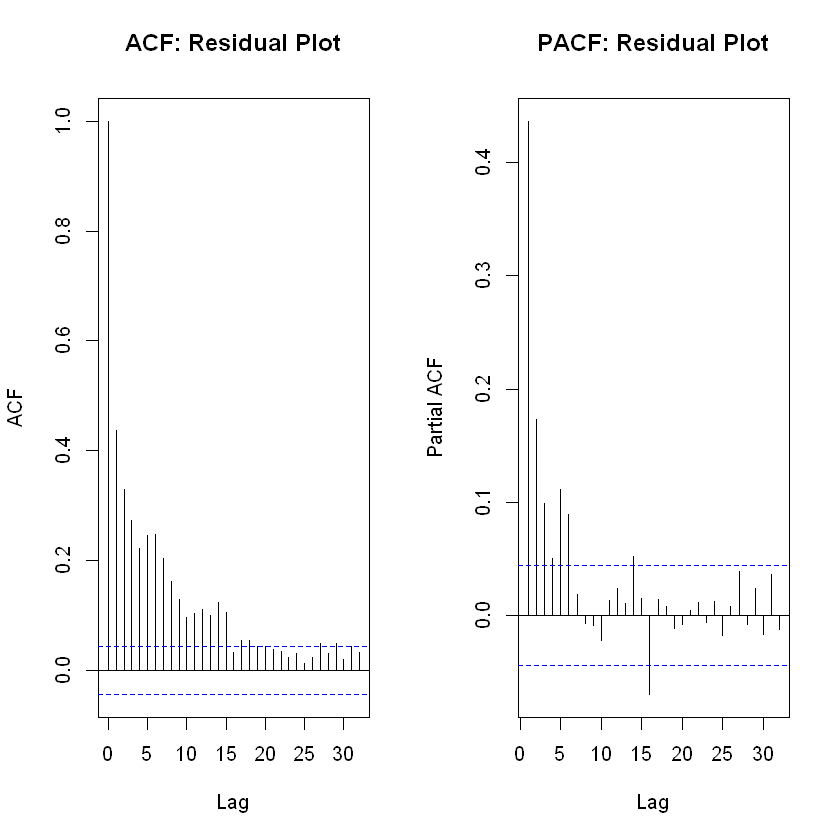

In [3]:
par(mfrow = c(1,2))
acf(resid.process, main="ACF: Residual Plot")
pacf(resid.process, main="PACF: Residual Plot")

## 4. Fit the model (AR and ARMA)
### 4.1 Fit AR(q)
here we only fit the AR model and scale the AIC plot the AIC plot for log 1 to 20. We can see from the `mod$order` and the scaled AIC plot that the selected order is 6. 

We also plot the roots of the AR polynomial with the unit circle to check the stationarity and causal process.

[1] 6


             Length Class  Mode     
order           1   -none- numeric  
ar              6   -none- numeric  
var.pred        1   -none- numeric  
x.mean          1   -none- numeric  
aic            21   -none- numeric  
n.used          1   -none- numeric  
n.obs           1   -none- numeric  
order.max       1   -none- numeric  
partialacf     20   -none- numeric  
resid        1977   -none- numeric  
method          1   -none- character
series          1   -none- character
frequency       1   -none- numeric  
call            3   -none- call     
asy.var.coef   36   -none- numeric  

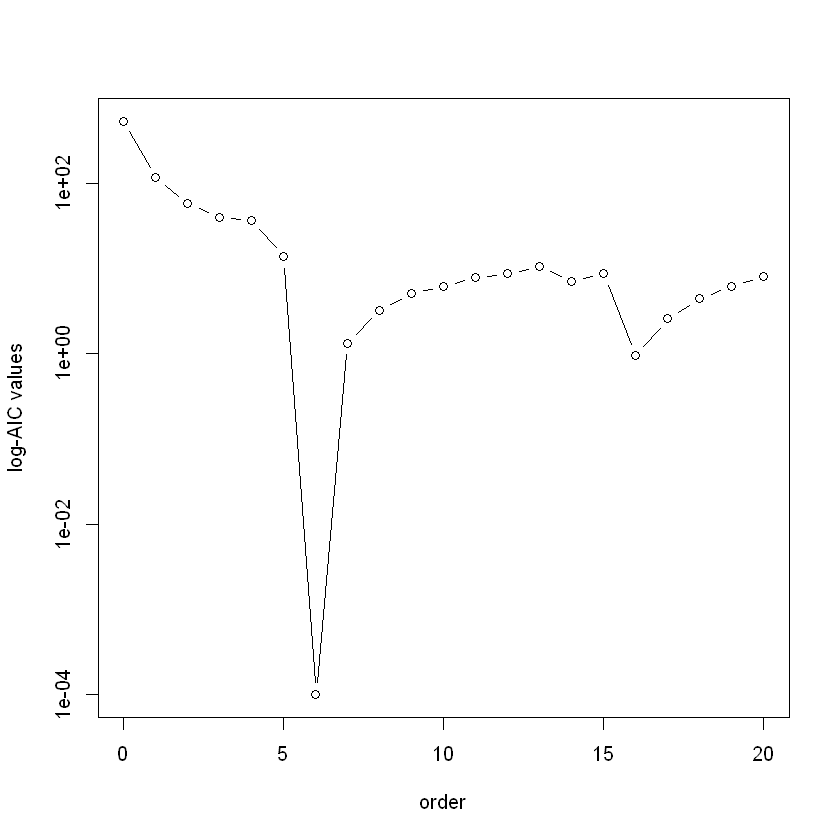

In [4]:
#fit AR(p) process for p<=order.max
mod=ar(resid.process,order.max=20)
#what is the selected order
print(mod$order)
summary(mod)
#plot AIC value on the log scale to easily identify minimum
plot(c(0:20),mod$aic+0.0001,type="b",log="y",xlab="order",ylab="log-AIC values")

We can also check if the roots of the polynnomial of fitted AR within the unit circle. If it's on the unit circle it indicate stationarity, if it's outside of the unit circle indictate the causal process

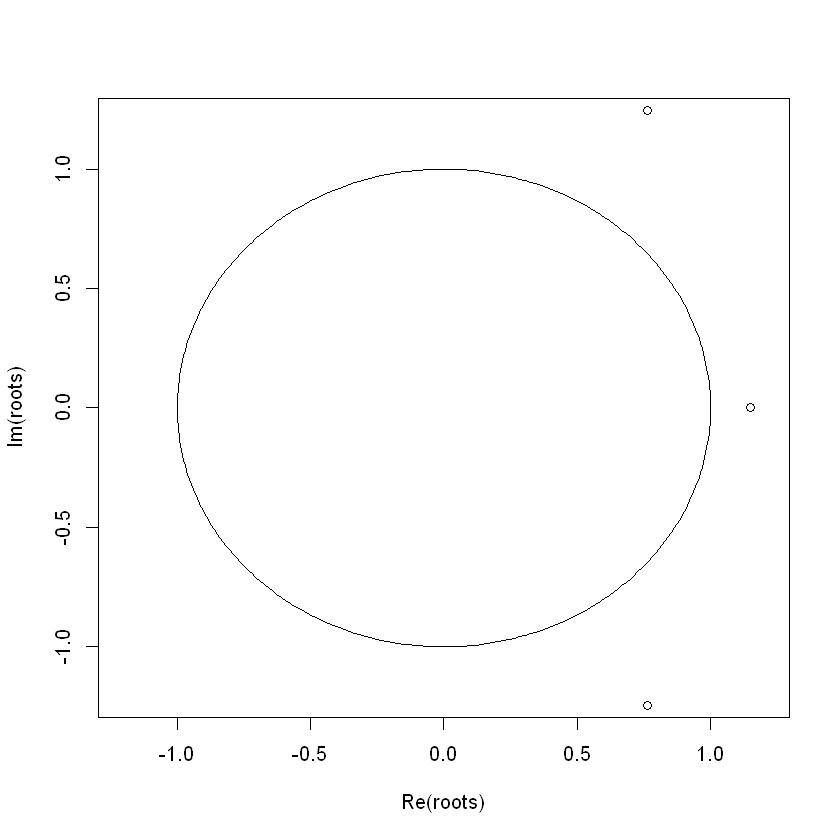

In [5]:
#Extract roots from the model output
roots=polyroot(c(1,(-mod$ar)))
#one corresponding to Xt and the -mod$ar are the lag Xt

##Adjust the x and y -axis limits to include the full circle
plot(roots,xlim=c(-1.2,1.2),ylim=c(-1.2,1.2))

##Draw a unit circle
lines(complex(arg=seq(0,2*pi,len=300)))

Access the residuals for stationarity and other properties
- extract the residuals from the fitted model using `mod$resid`
- plot residuals, ACF and PACF
- finally Q-Q normality plot

In [6]:
## Obtain the standerdized residuals
resids=mod$resid[(mod$order+1):length(mod$resid)]

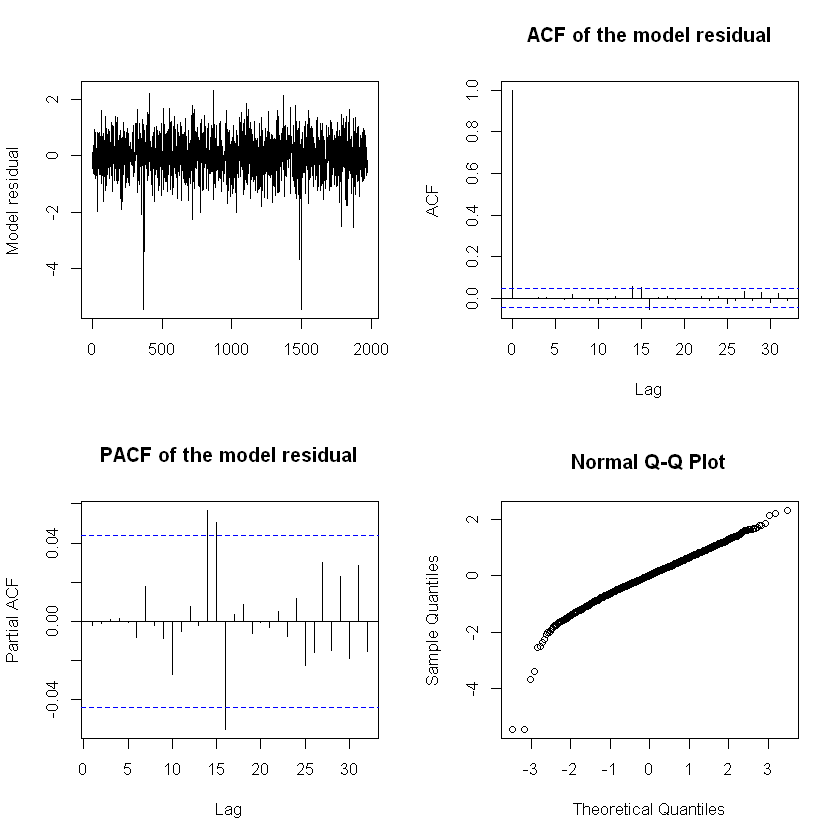

In [7]:
## Plot the residuals
par(mfrow=c(2,2))
plot(resids,type="l",xlab="",ylab="Model residual")
acf(resids,main="ACF of the model residual")
pacf(resids,main="PACF of the model residual")
qqnorm(resids)

1. residual plot shows no pattern, the variance is also constant
2. ACF only has first lag equal to one (others are small within the confidence band)
3. The same for the sample PACF.The values are all within the confidence band.
4. finall for QQ plot has a tail on the left

### 4.2. Fit the ARMA model (not only AR model)
we use `arima` to fit an ARMA model `method=ML` means that we fit using maximum likelihood assuming normality.

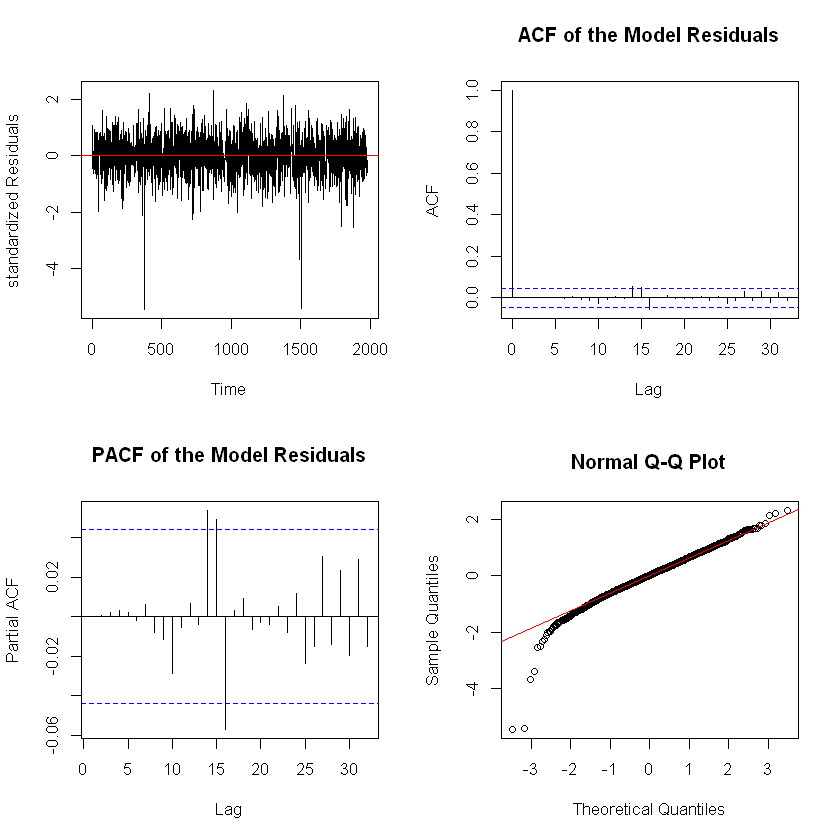

In [8]:
#try with ARMA(6,1)
modarma=arima(resid.process,order=c(6,0,1),method="ML")

##Residual analysis
par(mfrow=c(2,2))
plot(modarma$residuals,ylab="standardized Residuals")
abline(h=0,col='red')
acf(modarma$residuals,main="ACF of the Model Residuals")
pacf(modarma$residuals,main="PACF of the Model Residuals")
qqnorm(modarma$residuals)
qqline(modarma$residuals,col='red')

These are similar observations from fitting the AR model alone. And it's not surprising since we only added an MA(1) part to the AR(6) of the model

## 5. Order Selection

1. use EACF: `library(TSA)` function `eacf`
2. use AIC order selection

We can see that eacf has chosen many ARMA model orders, there's not a conclusive order selection using EACF

In [ ]:
##eacf
library(TSA)
eacf(resid.process,ar.max=6,ma.max=6)

##AIC (maximum order to be 6)
n=length(resid.process)
norder=7
p=c(1:norder)-1; q=c(1:norder)-1 #note that it start from 0
aic=matrix(0,norder,norder)
for (i in 1:norder){
    for(j in 1:norder){
        modij=arima(resid.process,order = c(p[i],0,q[j]),method="ML")
        aic[i,j]=modij$aic
    }
}

Warning message:
"package 'TSA' was built under R version 3.6.1"
Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar



AR/MA
  0 1 2 3 4 5 6
0 x x x x x x x
1 x o o x o x o
2 x x o x o o o
3 x o x x o o o
4 x x x x o o o
5 x x x x o o o
6 x x x x o x o


Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

In [ ]:
# which order to select
#plot(aic)
indexmin=which(aic==min(aic))
indexp=ceiling(indexmin/norder)-1
indexq=indexmin%%norder-1
print(c("order=",indexp,indexq))
## final moodel
final_model=arima(resid.process,order=c(indexp,0,indexq),method='ML')

In [ ]:
summary(final_model)

Now we plot the final model, The residuals do not improve or
change significantly from the smaller models, AR(6) or ARMA(6,1), suggesting that a smaller model than the one selected using the AIC approach may perform similarly in terms of goodness of fit.

Knowing that less complex model are preferred to avoid overfitting or to obtain better predictions.

In [ ]:
##Residual analysis
par(mfrow=c(2,2))
plot(final_model$residuals,ylab="standardized Residuals")
abline(h=0,col='red')
acf(final_model$residuals,main="ACF of the Model Residuals")
pacf(final_model$residuals,main="PACF of the Model Residuals")
qqnorm(final_model$residuals)
qqline(final_model$residuals,col='red')

# 6. Independence Test
We also need to check whether the residuals from the model fit are uncorrelated using `Box.test`

Here the null hypothesis is that the residuals from the model fit are uncorrelated. We can see that the null hypothesis for both model.

In [ ]:
## Test the independence for final model
Box.test(final_model$residuals, lag=(indexp+indexq+1),typ="Box-Pierce",fitdf=(indexp+indexq))
Box.test(final_model$residuals, lag=(indexp+indexq+1),typ="Ljung-Box",fitdf=(indexp+indexq))

## Test the independence for ARMA(6,1)
Box.test(modarma$residuals, lag=(indexp+indexq+1),typ="Box-Pierce",fitdf=(indexp+indexq))
Box.test(modarma$residuals, lag=(indexp+indexq+1),typ="Ljung-Box",fitdf=(indexp+indexq))
